In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join(".", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## 계획: 할 일 목록

![Screenshot 2025-08-15 at 11.41.46 AM.png](첨부 파일:e94d5803-050b-4502-b784-f520a96c322b.png)

많은 에이전트들은 장기적이고 복잡한 작업을 수행하는 데 필수적인 내비게이션 도구로 TODO 목록을 사용합니다. Claude Code는 [계획 모드](https://www.anthropic.com/engineering/claude-code-best-practices)를 활용하여 작업을 실행하기 전에 구조화된 TODO 목록을 생성하며, [Claude Code 프롬프트](https://cchistory.mariozechner.at/)를 기반으로 한 `TodoWrite`라는 특정 도구를 사용합니다. 각 TODO 항목은 두 가지 핵심 구성 요소로 이루어집니다: 내용(짧고 구체적인 작업 설명)과 상태(보류 중, 진행 중, 완료됨).

TODO 목록의 어려움은 컨텍스트 창이 커짐에 따라 주의를 유지하는 데 있습니다. 평균적인 Manus 작업은 약 50개의 도구 호출을 사용하며, 이는 상당한 [컨텍스트 부패](https://research.trychroma.com/context-rot) 위험을 초래합니다. 에이전트는 긴 대화나 복잡한 작업 중 주제에서 벗어나거나 초기 목표를 잊기 쉽습니다. Manus와 같은 에이전트는 TODO 목록을 지속적으로 재작성하고 업데이트함으로써 컨텍스트 종료 시점에 목표를 효과적으로 상기시켜 [작업에 집중](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)하고 임무 이탈을 방지합니다.

<!-- 아래 스타일은 동일한 글머리 기호 목록 내 항목 간 간격을 줄입니다. 노트북당 한 번 실행 -->
<style>
/* JupyterLab + classic notebook */
.jp-RenderedHTMLCommon ul, .text_cell_render ul { margin-top: .25em; margin-bottom: .35em; padding-left: 1.2em; }
.jp-RenderedHTMLCommon ul ul, .text_cell_render ul ul { margin-top: .15em; margin-bottom: .15em; padding-left: 1.0em; }
.jp-RenderedHTMLCommon li, .text_cell_render li { margin: .1em 0; }
</style>

### 상태

이전 강의와 마찬가지로 커스텀 상태를 가진 `create_react_agent`를 사용할 것입니다.

상태 객체는 워크플로우의 서로 다른 단계 간에 컨텍스트를 저장하고 전달하는 주요 메커니즘 역할을 합니다. 상태는 그래프의 스키마와 상태 업데이트 적용 방식을 지정하는 리듀서 함수로 구성됩니다.

DeepAgent 스키마에는 세 가지 주요 요소가 정의되어 있습니다: **`messages`**, **`todo`**, **`files`**.  

- **`messages`**는 첫 번째 강의에서 설명한 `AgentState`에서 상속됩니다.
  - `add_messages` 리듀서는 새 메시지를 메시지 목록 끝에 추가합니다.  
- **`todo`**는 `Todo` 작업 목록입니다. 각 작업은 설명(`content`)과 상태(`status`: pending, in_progress, completed)를 가집니다.
  - 사용자 정의 리듀서가 정의되지 않아, 업데이트 시 목록이 덮어쓰기됩니다.
- **`files`**는 상태 내에 포함된 가상 파일 시스템으로, 다음 강의에서 살펴볼 예정입니다.  


In [2]:
%%writefile ./src/deep_agents_from_scratch/state.py
"""TODO 추적 및 가상 파일 시스템을 지원하는 심층 에이전트용 상태 관리.

이 모듈은 다음을 지원하는 확장된 에이전트 상태 구조를 정의합니다:
- TODO 목록을 통한 작업 계획 및 진행 상황 추적
- 상태에 저장된 가상 파일 시스템을 통한 컨텍스트 오프로딩
- 리듀서 함수를 통한 효율적인 상태 병합
"""

from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """ 워크플로우를 통해 진행 상황을 추적하기 위한 구조화된 작업 항목.

    Attributes:
        content: 작업에 대한 간결하고 구체적인 설명
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """두 파일 사전(dictionary)을 병합하며, 오른쪽이 우선합니다.

    에이전트 상태의 files 필드에 대한 리듀서 함수로 사용되며,
    가상 파일 시스템에 대한 증분 업데이트를 가능하게 합니다.
    
    Args:
        left: 왼쪽 사전 (기존 파일)
        right: 오른쪽 사전 (새/업데이트된 파일)

    Returns:
        오른쪽 값이 왼쪽 값을 덮어쓴 병합된 사전
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """작업 추적 및 가상 파일 시스템을 포함하는 확장 에이전트 상태.

    LangGraph의 AgentState를 상속하며 다음을 추가합니다:
    - todos: 작업 계획 및 진행 상황 추적을 위한 할 일 항목 목록
    - files: 파일명을 콘텐츠에 매핑하는 딕셔너리로 저장된 가상 파일 시스템
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

Overwriting ./src/deep_agents_from_scratch/state.py


### 도구 설명  - 할 일 도구
위에서 설명한 바와 같이, 장시간 실행되는 에이전트는 할 일 목록을 활용하여 작업을 계속 진행할 수 있습니다. 이를 가능하게 하기 위해 `write_todo` 및 `read_todo`라는 할 일 도구가 생성됩니다. 아래의 도구 설명은 LLM에 제공되며, 할 일 목록을 언제 사용해야 하는지, 목록에 무엇이 포함되는지, 그리고 목록을 읽고 업데이트하는 방법을 상세히 설명합니다.   
참고: 목록에는 개별 작업이 포함되지만, 목록 전체를 재작성하는 방식으로 업데이트됩니다. 이를 통해 LLM은 작업 진행 상황에 따라 작업을 재고할 수 있습니다. 



In [3]:
from notebooks.utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  복잡한 워크플로우의 진행 상황을 추적하기 위해 구조화된 작업 목록을 생성하고 관리합니다.                        │
│                                                                                                                 │
│  ## 사용 시점                                                                                                   │
│  - 조정이 필요한 다단계 또는 간단하지 않은 작업                                                                 │
│  - 사용자가 여러 작업을 제공하거나 명시적으로 할 일 목록을 요청할 때                                            │
│  - 별도의 지시가 없는 한 단일의 사소한 작업에는 사용을 피하세요                                                 │
│                                                                                                                 │
│  ## 구조                                                                                                        │
│  - 여러 할 일 객체(내용, 상태, ID)를 포함하는 하나의 목록을 유지합니다.                                         │
│  - 명확하고 실행 가능한 내용 설명을 사용하세요                                                                  │
│  - 상태는 반드시 pending, in_progress, 또는 completed여야 합니다.                                               │
│                                                                                                                 │
│  ## 모범 사례                                                                                                   │
│  - 한 번에 하나의 작업만 in_progress 상태일 수 있습니다.                                                        │
│  - 작업이 완전히 완료되면 즉시 completed로 표시하세요                                                           │
│  - 변경 시 항상 업데이트된 전체 목록을 보내세요                                                                 │
│  - 목록을 집중적으로 유지하기 위해 관련 없는 항목은 제거하세요                                                  │
│                                                                                                                 │
│  ## 진행 상황 업데이트                                                                                          │
│  - 작업 상태를 변경하거나 내용을 편집하려면 TodoWrite를 다시 호출하세요                                         │
│  - 실시간 진행 상황을 반영하세요. 완료를 일괄 처리하지 마세요.                                                  │
│  - 작업이 막히면 in_progress 상태를 유지하고, 방해 요소를 설명하는 새 작업을 추가하세요                         │
│                                                                                                                 │
│  ## 매개변수                                                                                                    │
│  - todos: 내용(content)과 상태(status) 필드를 가진 TODO 항목의 목록                                             │
│                                                                                                                 │
│  ## 반환값                                                                                                      │
│  에이전트 상태를 새 할 일 목록으로 업데이트합니다.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### 할 일 도구 쓰기 및 읽기  

아래에서 **`write_todos`** 및 **`read_todos`** 도구를 생성합니다:  
**`write_todos`** 도구는 LLM으로부터 할 일 목록을 인수로 받아 상태에 기록하며, 기존 목록을 덮어씁니다. 이후 기록된 목록을 포함하는 `ToolMessage`를 반환합니다. 목록을 작성하면 해당 정보가 `messages`에 저장된 대화 기록을 통해 LLM에 제공됩니다. 이는 LLM이 생성한 도구 호출과 반환된 `ToolMessage` 모두에 적용됩니다.  

**`read_todos`** 도구는 상태에서 할 일 목록을 읽고 `ToolMessage`로 반환합니다. LLM 컨텍스트의 정보를 새로 고치는 데 사용할 수 있습니다.  


이 도구들은 이전 강의에서 논의된 기능들을 사용합니다:

- 그래프 상태에 대한 도구 접근을 제공하는 `InjectedState`.
- 상태 값을 업데이트하는 `Command`.


In [4]:
%%writefile ./src/deep_agents_from_scratch/todo_tools.py
"""작업 계획 및 진행 상황 추적을 위한 TODO 관리 도구.

이 모듈은 구조화된 작업 목록을 생성하고 관리하는 도구를 제공하여
에이전트가 복잡한 워크플로를 계획하고 다단계 작업을 통해 진행 상황을 추적할 수 있도록 합니다.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo


@tool(description=WRITE_TODOS_DESCRIPTION,parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """작업 계획 및 추적을 위해 에이전트의 TODO 목록을 생성하거나 업데이트합니다.

    Args:
        todos: 내용과 상태가 포함된 할 일 항목 목록
        tool_call_id: 메시지 응답을 위한 도구 호출 식별자

    Returns:
        새로운 TODO 목록으로 에이전트 상태를 업데이트하는 명령어
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )


@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """에이전트 상태에서 현재 TODO 목록을 읽습니다.

    이 도구를 통해 에이전트는 현재 TODO 목록을 조회하고 검토하여
    남은 작업에 집중하고 복잡한 워크플로우를 통해 진행 상황을 추적할 수 있습니다.

    Args:
        state: 현재 TODO 목록을 포함하는 주입된 에이전트 상태
        tool_call_id: 메시지 추적을 위한 주입된 도구 호출 식별자

    Returns:
        현재 TODO 목록의 형식화된 문자열 표현
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    return result.strip()

Overwriting ./src/deep_agents_from_scratch/todo_tools.py


### 그래프  

첫 번째 강의에서와 마찬가지로 `create_react_agent`를 사용해 에이전트를 구축할 것입니다.  에이전트가 할 일 목록을 활용하도록 만드는 데 집중할 예정입니다. 각 작업 후 할 일 목록을 다시 확인하는 Manus 접근법을 따르며, 위에서 방금 생성한 도구들을 활용할 것입니다.

In [5]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  사용자의 요청에 따라:                                                                                          │
│  1. 도구 설명에 따라 사용자 요청 시작 시 write_todos 도구를 사용하여 TODO를 생성합니다.                         │
│  2. TODO를 완료한 후, read_todos를 사용하여 계획을 상기하기 위해 TODO 목록을 읽습니다.                          │
│  3. 수행한 작업과 TODO를 성찰합니다.                                                                            │
│  4. 작업을 완료됨으로 표시하고 다음 TODO로 진행합니다.                                                          │
│  5. 모든 TODO를 완료할 때까지 이 과정을 계속합니다.                                                             │
│                                                                                                                 │
│  중요: 모든 사용자 요청에 대해 항상 TODO 연구 계획을 수립하고 위 지침에 따라 연구를 수행하세요.                 │
│  중요: 추적해야 할 TODO의 수를 최소화하기 위해 연구 작업을 *단일 TODO*로 묶는 것을 목표로 하세요.               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

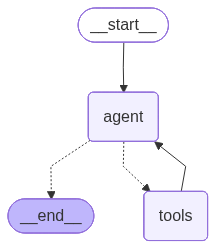

In [6]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from notebooks.utils import format_messages

from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tools import read_todos, write_todos

# Mock search result
search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로, 
AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. 
이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 합니다. 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써
AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다."""


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """특정 주제에 대한 정보를 웹에서 검색합니다.

    이 도구는 웹 검색을 수행하고 주어진 쿼리에 대한 관련 결과를 반환합니다.
    인터넷에서 어떤 주제에 대한 정보를 수집해야 할 때 사용하세요.

    Args:
        query: 검색 쿼리 문자열. 찾고자 하는 정보에 대해 구체적이고 명확하게 작성하세요.

    Returns:
        검색 엔진에서 반환된 검색 결과.

    Example:
        web_search(“의료 분야에서의 머신 러닝 응용”)
    """
    return search_result


# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4.1-mini", temperature=0.0)
tools = [write_todos, web_search, read_todos]

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """중요: web_search 도구에 단 한 번만 호출을 수행하고, 해당 도구가 제공하는 결과를 사용하여 사용자의 질문에 답변하십시오."""

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

상태에 `todos`가 없고 사용자 연구 요청이 있는 상태로 그래프를 시작합니다. 

In [7]:
# Example usage
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "모델 컨텍스트 프로토콜(MCP)에 대한 간략한 요약을 제공해 주세요.",
            }
        ],
        "todos": [],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 간략한 요약을 제공해 주세요.                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서 검색한다.",              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_9Cf6LPCcxBK1IDTvLzwi2XFY                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': '모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서         │
│ 검색한다.', 'status': 'pending'}]                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서 검색한다.",              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_D4Lsjm5ZJlLrPTIVoIjLZgSb                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': '모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서         │
│ 검색한다.', 'status': 'in_progress'}]                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP"                                                                         │
│ }                                                                                                               │
│    ID: call_5KGbowWOvzGwhtf8cFSvie0y                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로,                                        │
│ AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다.                │
│ 이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 │
│ 수 있도록 합니다. 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써                                  │
│ AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다.                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서 검색한다.",              │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_FTeQ384k3irrckrsHndLmkhe                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': '모델 컨텍스트 프로토콜(MCP)에 대한 신뢰할 수 있는 최신 정보를 웹에서         │
│ 검색한다.', 'status': 'completed'}]                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로, AI 모델과 도구, 데이터베이스, 기타     │
│ 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. MCP는 표준화된 통신 계층 역할을 하여 AI 모델이    │
│ 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 하며, 데이터 교환을 위한 통합       │
│ 언어를 제공함으로써 AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/7e771e79-8996-4833-8242-2b3559c2c1d7/r
<!-- https://smith.langchain.com/public/57e530e5-c3bb-4ed6-aff6-c57d06158fe9/r  -->